# 2 практическое задание. Сегментация изображений.

## Практикум на ЭВМ для 317 группы, весна 2021

#### Фамилия, имя: Кузнецов Михаил

Дата выдачи: 18 марта 00:00

Мягкий дедлайн: 1 апреля 23:59 

В этом задании вы будете решать задачу сегментации людей на фотографии с помощью нейросетевых архитектур Unet и Linknet. 

Ссылка на данные: https://yadi.sk/d/-ug82uwhSuLYrA

## Загрузка данных (1 балл)

Для загрузки данных pytorch опирается на такую сущность, как **`Dataset`**.

Этот абстрактный класс определен в `torch.utils.data.dataset`:

```python
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
```
При определении нового источника данных мы создаем наследника данного класса и реализуем методы `__getitem__` и `__len__`.

Пример готового такого класса — `torchvision.datasets.ImageFolder`, который позволяет создать датасет на основе директории с imagenet-подобной структурой поддиректорий (`./train/{class}` и `./val/{class}`):

```python
imagenet = torchvision.datasets.ImageFolder('path/to/imagenet_root/')
```

Реализуйте класс PhotosDataset для выданных данных.

**Внимание.** Возможно, стоит прочитать следующий пункт задания, чтобы реализация была удобной.

In [ ]:
!pip install pytorch_lightning
# !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --version nightly --apt-packages libomp5 libopenblas-dev

In [ ]:
import torch

In [ ]:
import os
os.environ['XLA_USE_BF16']="1"
os.environ['XLA_TENSOR_ALLOCATOR_MAXSIZE'] = '100000000'

import torch
import pandas as pd
from scipy import stats
import numpy as np

from tqdm import tqdm
from collections import OrderedDict, namedtuple
import torch.nn as nn
from torch.optim import lr_scheduler
import joblib

import logging
import sys
from sklearn import metrics, model_selection

import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pathlib
import torch

from pytorch_lightning.callbacks import ModelCheckpoint
import pytorch_lightning as py_l

import torch
import torch.nn as nn
import torchvision as tvis

import numpy as np
import pandas as pd
import numpy.testing as npt
import matplotlib.pyplot as plt
import seaborn as sns

from torchvision.models import vgg13
from torch.utils.data import Dataset, DataLoader
from google.colab import drive
import functools
from PIL import Image
import PIL as pil
import os, os.path
import gc
from IPython import display
import torch.nn.functional as F
from timeit import default_timer as timer
import pickle

%pylab inline
sns.set(style="darkgrid")
sns.set_palette("tab10")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
drive.mount('/content/drive')
path = '/content/drive/MyDrive/6_sem/practicum/2/'

Mounted at /content/drive


In [ ]:
class PhotosDataset(Dataset):
    def __init__(self, images_dir, target_dir=None, background_path=None, not_my_transforms=[], need_mask_transf=[], transforms=None):
        """
        Arguments
        ---------
        images_dir : str
            Path to directory with images
            
        target_dir : str
            Path to directory with masks.
            Each mask corresponds to one image.
            Corresponding mask and image have the same name, but different format.
            
        transforms : some collection
            Sequence of transformations for images and masks. 
        """
        self.images_dir = images_dir
        self.target_dir = target_dir
        self.transforms = transforms
        self.not_my_transforms = not_my_transforms
        self.need_mask_transf = need_mask_transf

        self.train_names = [name for name in os.listdir(self.images_dir)]
        self.backgrounds = []
        if background_path:
            for name in os.listdir(background_path):
                self.backgrounds.append(Image.open(background_path + name))
        
    def __len__(self):
        return len(self.train_names)
                   
    def __getitem__(self, idx):
        """
        Arguments
        ---------
        idx : int
            Index of image and mask
    
        Returns
        -------
        (image, mask)
        """
        img = Image.open(self.images_dir + self.train_names[idx])
        tar = Image.open(self.target_dir + self.train_names[idx][:-4] + '.png')

        params = {
            'img': img,
            'targ': tar,
            'bg_list': self.backgrounds
        }

        if self.transforms:
            ind = 0
            for tr in self.transforms:
                if ind not in self.not_my_transforms:
                    params = tr(**params)
                else:
                    params['img'] = tr(params['img'])
                    if ind in self.need_mask_transf:
                        params['targ'] = tr(params['targ'])
                ind += 1
        
        return params['img'], params['targ']
    
    def __add__(self, other):
        return ConcatDataset([self, other])

## Модуль аугментации (3 балла)

Конструктор стандартного `ImageFolder`, принимают параметр `transform` (и иногда `target_transform`).

Они служат для того, чтобы загружаемые изображения (обычно это `PIL.Image`) или таргеты преобразовывать в тензоры нужного вида.

В `torchvision` входит модуль `transforms` для стандартных примеров таких преобразований. В `transforms` могут содержаться случайные преобразования, это самый простой путь для реализации аугментации данных.

При определении кастомного трансформера помимо конструктора нужно реализовать лишь метод `__call__`:

```python
class HorizontalFlip(object):
    def __init__(self, mode=0):
        self.method = mode

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        if self.method:
            return img.transpose(Image.FLIP_LEFT_RIGHT)
        return img

```

С полным списком стандартных преобразований можно ознакомиться в http://pytorch.org/docs/master/torchvision/transforms.html.

В данной части вам предлагается самостояльно реализовать несколько кастомных трансформеров.
Обратите внимание, что для некоторых трансформеров, необходимо преобразовывать и изображение, и маску, а для каких-то только изображение.

Один из путей реализации:
* реализовать декоратор, делающий любое преобразование случайным
* реализовать декоратор, применяющий преобразование и к изображению, и к маске

Список трансформеров, которые надо реализовать:

* случайное (с вероятностью p) горизонтальное отображение (flip) изображения 
* случайное (с веротностью p) вырезание фрагмента изображения (заданного или случайного размера)
* случайное (с вероятностью p) изменение яркости изображения (на заданную или случайную величину)
* случайное (с веротностью p) изменение фона изображения (на изображение из заданного списка изображений)

In [ ]:
def with_probability(f):
    @functools.wraps(f)
    def wrapper_function(*args, **kwargs):
        p = args[0].p
        args[0].transform = np.random.choice([False, True], size=1, p=[1-p, p])[0]
        return f(*args, **kwargs)
    return wrapper_function

class HorizontalFlip(object):
    def __init__(self, p=1):
        """
        p: Probability of transformation
        """
        self.p = p
        self.transform = True

    @with_probability
    def __call__(self, **params):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        if self.transform:
            params['img'] = params['img'].transpose(Image.FLIP_LEFT_RIGHT)
            params['targ'] = params['targ'].transpose(Image.FLIP_LEFT_RIGHT)
        return params


class Crop(object):
    def __init__(self, p=1, random=True, w=0.8, h=0.8):
        """
        p: Probability of transformation
        w: Percent of the width of real img width
        h: Percent of the width of real img height
        """
        self.p = p
        self.transform = True
        self.random = random
        self.w = w
        self.h = h

    @with_probability
    def __call__(self, **params):
        if self.transform:
            img_w = params['img'].width
            img_h = params['img'].height

            w = self.w
            h = self.h

            if self.random:
                w = np.random.uniform(0.7, 0.9)
                h = np.random.uniform(0.7, 0.9)

            w = int(w * img_w)
            h = int(h * img_h)
            
            lx = int(np.random.uniform(0, img_w - w - 1))
            ly = int(np.random.uniform(0, img_h - h - 1))
            
            rx = lx + w
            ry = ly + h

            params['img'] = params['img'].crop((lx, ly, rx, ry)).resize((img_w, img_h), resample=pil.Image.NEAREST)
            params['targ'] = params['targ'].crop((lx, ly, rx, ry)).resize((img_w, img_h), resample=pil.Image.NEAREST)

        return params


class Erase(object):
    def __init__(self, p=1, random=True, w=0.05, h=0.1):
        """
        p: Probability of transformation
        w: Percent of the width of real img width
        h: Percent of the width of real img height
        """
        self.p = p
        self.transform = True
        self.random = random
        self.w = w
        self.h = h

    @with_probability
    def __call__(self, **params):
        if self.transform:
            img_w = params['img'].width
            img_h = params['img'].height

            w = self.w
            h = self.h

            if self.random:
                w = np.random.uniform(0.05, 0.1)
                h = np.random.uniform(0.05, 0.1)

            w = int(w * img_w)
            h = int(h * img_h)
            
            lx = int(np.random.uniform(0, img_w - w - 1))
            ly = int(np.random.uniform(0, img_h - h - 1))
            
            rx = lx + w
            ry = ly + h

            params['img'].paste((255, 255, 255), box=(lx, ly, rx, ry))
            params['targ'].paste((0), box=(lx, ly, rx, ry))
        return params


class Brightness(object):
    def __init__(self, p=1, random=True, factor=0.5):
        """
        p: Probability of transformation
        factor: scale brightness by this value
        """
        self.p = p
        self.transform = True
        self.random = random
        self.factor = factor

    @with_probability
    def __call__(self, **params):
        if self.transform:
            enh = pil.ImageEnhance.Brightness(params['img'])
            factor = self.factor

            if self.random:
                factor = np.random.uniform(0.5, 1.5)

            params['img'] = enh.enhance(factor)
        return params


class ChangeBackground(object):
    def __init__(self, p=1):
        """
        p: Probability of transformation
        """
        self.p = p
        self.transform = True

    @with_probability
    def __call__(self, **params):
        '''
        mask: backgound - black
        bg_list: must have same (w,h) as img
        '''
        if self.transform:
            ind = np.random.choice(len(params['bg_list']))
            params['img'].paste(params['bg_list'][ind].crop((0, 0, params['img'].width, params['img'].height)),
                                mask=pil.ImageOps.invert(params['targ']))
        return params

Добавьте случайные преобразования в ваши датасеты. Также, добавьте преобразование в tensor и нормализацию для изображения:

```
transforms.ToTensor()
transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
```

In [ ]:
DATA_PATH = path

train_transforms = [
    Crop(0.5),
    HorizontalFlip(0.5),
    Brightness(0.5),
    ChangeBackground(0.01),
    # Erase(0),
    tvis.transforms.ToTensor(),
    tvis.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
]

test_transforms = [
    tvis.transforms.ToTensor(),
    tvis.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
]

not_my_transforms_train = [len(train_transforms) - 2, len(train_transforms) - 1]
not_my_transforms_test = [len(test_transforms) - 2, len(test_transforms) - 1]
need_mask_transf_train = [len(train_transforms) - 2]
need_mask_transf_test = [len(test_transforms) - 2]

train_dataset = PhotosDataset(
    images_dir=DATA_PATH + 'train/',
    target_dir=DATA_PATH + 'train_mask/',
    transforms=train_transforms,
    not_my_transforms=not_my_transforms_train,
    need_mask_transf=need_mask_transf_train,
    background_path=DATA_PATH + 'background/'
)

test_dataset = PhotosDataset(
    images_dir=DATA_PATH + 'test/',
    target_dir=DATA_PATH + 'test_mask/',
    transforms=test_transforms,
    need_mask_transf=need_mask_transf_test,
    not_my_transforms=not_my_transforms_test,
    background_path=DATA_PATH + 'background/'
)

Функция для отображения изображения:

In [ ]:
def show_idx_image(dataset, idx):
    mask_img = dataset[idx]

    image_to_show = mask_img[0].transpose(0, 1).transpose(1, 2).numpy()
    image_to_show = (image_to_show * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    image_to_show = np.clip(image_to_show, 0, 1)

    mask_to_show = mask_img[1][0].numpy()

    fig, ax = plt.subplots(1, 3)
    fig.set_figwidth(7)
    fig.set_figheight(3)


    plt.subplot(1, 2, 1)
    plt.imshow(image_to_show)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask_to_show)
    plt.axis('off')

Отобразите несколько изображений и масок, на которых будет видна правильная работа вашего модуля аугментации данных.

(None, None, None, None)

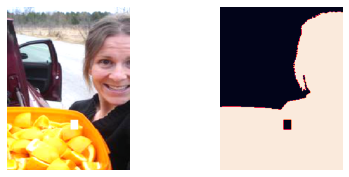

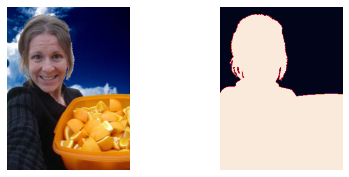

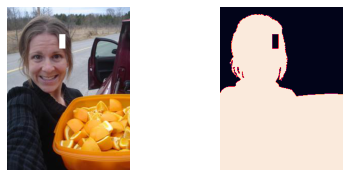

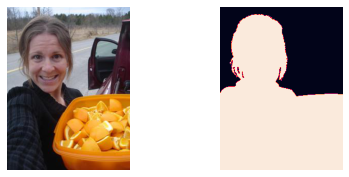

In [ ]:
show_idx_image(train_dataset, 222), show_idx_image(train_dataset, 222), show_idx_image(train_dataset, 222), show_idx_image(train_dataset, 222)

## Загрузчики

При обучении сети удобнее работать не с датасетами, а с загрузчиками. Загрузчики создаются на основе датасета и позволяют итерироваться по батчам из него.

Обратите внимание на параметры DataLoader. При num_workers > 1, батчи готовятся (загружаются картинки, обрабатываются и т.д.) сразу в нескольких фоновых процессах. С помощью параметра shuffle можно подавать картинки на обучение в случайном порядке.

In [ ]:
train_data_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
test_data_loader = DataLoader(test_dataset, batch_size=8, num_workers=2, pin_memory=True)

## DiceLoss (1 балл)

Функция потерь реализовывается как и все стандартные нейронные модули в pytorch, через nn.Module. В ячейке ниже вам предлагается реализовать фукцию потерь dice (аналог меры Джаккарда).

Результат dice loss определим как:

$$
1 - \frac{2\sum_{i, j}a_{ij}b_{ij}}{\sum_{ij}(a_{ij} + b_{ij} + \varepsilon)}
$$

где $a_{ij} \in [0, 1]$ — предсказанная вероятность нахождения человека в пикселе изображения, $b_{ij}$ — разметка для пикселя изображения.

В других источниках находил такое определение DiceLoss:
$$
D=1 - \frac{2 \sum_{i}^{N} p_{i} g_{i}}{\sum_{i}^{N} p_{i}^{2}+\sum_{i}^{N} g_{i}^{2}}
$$

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, eps=1e-7, reduction='mean', with_logits=True):
        """
        Arguments
        ---------
        eps : float
            eps in denominator
        reduction : Optional[str] (None, 'mean' or 'sum')
            specifies the reduction to apply to the output:
            
            None: no reduction will be applied
            'mean': the sum of the output will be divided by the number of batches in the output
            'sum':  the output will be summed. 
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()
        self.eps = eps
        self.reduction = reduction
        self.with_logits = with_logits
        
    def forward(self, logits, true_labels):
        true_labels = true_labels.long()
        
        if self.with_logits:
            logits = torch.sigmoid(logits)
        
        shapes = tuple(range(1, true_labels.ndim))
        loss_value = 1 - 2 * (true_labels * logits).sum(dim=shapes) / ((true_labels + logits).sum(dim=shapes) + self.eps)
        
        if self.reduction == 'sum':
            loss_value = loss_value.sum()
        elif self.reduction == 'mean':
            loss_value = loss_value.mean()
        
        return loss_value

class DiceLoss_2(nn.Module):
    def __init__(self, eps=1e-7, reduction='mean', with_logits=True):
        """
        Arguments
        ---------
        eps : float
            eps in denominator
        reduction : Optional[str] (None, 'mean' or 'sum')
            specifies the reduction to apply to the output:
            
            None: no reduction will be applied
            'mean': the sum of the output will be divided by the number of batches in the output
            'sum':  the output will be summed. 
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()
        self.eps = eps
        self.reduction = reduction
        self.with_logits = with_logits
        
    def forward(self, logits, true_labels):
        true_labels = true_labels.float()
        shapes = tuple(range(1, true_labels.ndim))
        
        if self.with_logits:
            logits = torch.sigmoid(logits)
        
        sq = true_labels + logits
        sq = sq ** 2
        
        prod = 2 * true_labels * logits
        
        loss_value = 1 - prod.sum(dim=shapes) / ((sq - prod).sum(dim=shapes) + self.eps)

        if self.reduction == 'sum':
            loss_value = loss_value.sum()
        elif self.reduction == 'mean':
            loss_value = loss_value.mean()
        
        return loss_value

Проверка реализации:

In [ ]:
logits = torch.tensor([
    [[0, 0.5], [0.5, 1]],
    [[0.1, 0.1], [0, 0]],
])

target = torch.tensor([
    [[0, 1], [1, 1]],
    [[1, 0], [0, 1]],
])

losses = DiceLoss(with_logits=False, reduction=None, eps=1e-7)(logits, target)
npt.assert_almost_equal(losses.numpy(), np.array([0.2, 0.90909]), decimal=4)

loss = DiceLoss(with_logits=False, reduction='mean', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 0.554545, decimal=4)

loss = DiceLoss(with_logits=False, reduction='sum', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 1.10909, decimal=4)

## Unet (2 балла)

Для решения задачи сегментации будем использовать UNet (https://arxiv.org/pdf/1505.04597.pdf) с энкодером из первых блоков предобученного VGG13. Архитектура сети реализована за вас ниже.

Энкодер:

In [ ]:
class VGG13Encoder(torch.nn.Module):
    def __init__(self, num_blocks, pretrained=True):
        super().__init__()
        self.num_blocks = num_blocks
        self.blocks = nn.ModuleList()
        # Obtaining pretrained VGG model from torchvision.models and
        # copying all layers except for max pooling.
        feature_extractor = vgg13(pretrained=pretrained).features
        for i in range(self.num_blocks):
            self.blocks.append(
                torch.nn.Sequential(*[feature_extractor[j]
                                      for j in range(i * 5, i * 5 + 4)]))

    def forward(self, x):
        activations = []
        for i in range(self.num_blocks):
            x = self.blocks[i](x)
            activations.append(x)
            if i != self.num_blocks - 1:
                x = torch.functional.F.max_pool2d(x, kernel_size=2, stride=2)
        return activations

Декодер:

In [ ]:
class DecoderBlock(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.relu = nn.ReLU()
    def forward(self, down, left):
        x = torch.nn.functional.interpolate(down, scale_factor=2)
        x = self.upconv(x)
        x = self.relu(self.conv1(torch.cat([left, x], 1)))
        x = self.relu(self.conv2(x))
        return x

In [ ]:
class Decoder(nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        for i in range(num_blocks):
            self.add_module(f'block{num_blocks - i}', DecoderBlock(num_filters * 2**i))

    def forward(self, acts):
        up = acts[-1]
        for i, left in enumerate(acts[-2::-1]):
            up = self.__getattr__(f'block{i + 1}')(up, left)
        return up

Сеть Unet:

In [ ]:
class UNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_filters=64, num_blocks=4):
        super().__init__()
        self.end_act = torch.sigmoid
        self.encoder = VGG13Encoder(num_blocks=num_blocks)
        self.decoder = Decoder(num_filters=64, num_blocks=num_blocks - 1)
        self.final = torch.nn.Conv2d(
            in_channels=num_filters, out_channels=num_classes, kernel_size=1
        )

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x

Функция для оценивания качества сети:

In [ ]:
def evaluate_net(net, testloader, criterion, val_criterion, device='cpu'):
    net = net.eval()

    loss = 0.
    correct = 0.
    total = 0.
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            
            images = images.to(device)
            
            outputs = net(images).to('cpu')
            total += labels.size(0)
            loss += float(criterion(outputs, labels).detach())
            correct += float(val_criterion(outputs, labels).detach())
    
    mean_loss = loss / total
    metric = correct / total
    
    return mean_loss, metric

Теперь применим сеть на практике!

Обучите сеть на обучающей выборке и протестируйте качество на тестовой выборке. 

Сначала при обучении используйте только кросс-энтропию (torch.nn.BCEWithLogitsLoss будет более удобна для бинарного случая). Зафиксируйте результат.

Сравните между собой несколько стратегий оптимизации (только кросс-энтропия, только dice loss, сумма двух лоссов с весами). 

Для всех экспериментов отобразите графики функции потерь и качества за время обучения. Выведите получившиеся маски для нескольких изображений из датасета. Сделайте выводы.

In [ ]:
class BCE_and_DiceLoss(nn.Module):
    def __init__(self, eps=1e-7, reduction='mean', with_logits=True, dice_coef=0.3, bce_coef=0.7):
        """
        Arguments
        ---------
        eps : float
            eps in denominator
        reduction : Optional[str] (None, 'mean' or 'sum')
            specifies the reduction to apply to the output:
            
            None: no reduction will be applied
            'mean': the sum of the output will be divided by the number of batches in the output
            'sum':  the output will be summed. 
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()
        self.dice_coef = dice_coef
        self.bce_coef = bce_coef

        self._DiceLoss = DiceLoss(eps, reduction, with_logits)
        self._BCEWithLogitsLoss = torch.nn.BCEWithLogitsLoss(reduction=reduction)
        
    def forward(self, logits, true_labels):
        return self.dice_coef * self._DiceLoss(logits, true_labels) + self.bce_coef * self._BCEWithLogitsLoss(logits, true_labels)


def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor, reduction='mean'):
    SMOOTH = 1e-6
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    if reduction == 'mean':
        return thresholded.mean()
    elif reduction == 'sum':
        return thresholded.sum()
    else:
        return thresholded


def show_masks(l, r=None, true=None):
    temp_names = ['previous model', 'current model', 'true mask']
    if r is None:
        temp_names[1] = ''
        r = np.full_like(l, 255)

    temp = [l, r, true]
    fig, axs = plt.subplots(1, 3, figsize=(10, 3 * 5))

    for ind in range(3):
        axs[ind].set_title(temp_names[ind])
        axs[ind].imshow(temp[ind])
        axs[ind].axis('off')

    fig.tight_layout()
    plt.show()


def get_most_dif_masks(pre, post=None):
    top_N = 3
    pre = np.array(pre).squeeze(2)
    pre[0, :, :, :] = expit(pre[0, :, :, :])
    pre[0, :, :, :][pre[0, :, :, :] >= 0.5] = 1
    pre[0, :, :, :][pre[0, :, :, :] < 0.5] = 0
    
    if post is not None:
        post = np.array(post).squeeze(2)
        post[0, :, :, :] = expit(post[0, :, :, :])
        post[0, :, :, :][post[0, :, :, :] >= 0.5] = 1
        post[0, :, :, :][post[0, :, :, :] < 0.5] = 0
        most_diff = np.argsort(np.sum(np.abs(pre[0] - post[0]).reshape(pre.shape[1], -1), axis=1))[::-1]
        for i in range(top_N):
            show_masks(pre[0, most_diff[i], :, :], post[0, most_diff[i], :, :], pre[1, most_diff[i], :, :])
    else:
        most_diff = np.random.randint(0, pre.shape[1], size=top_N)
        for i in range(top_N):
            show_masks(pre[0, most_diff[i], :, :], post, pre[1, most_diff[i], :, :])


def get_preds_model(model, test_loader, device='cpu'):
    fin_targets = []
    fin_outputs = []

    with torch.no_grad():
        model.eval()

        for batch_idx, (data, target) in enumerate(test_loader):
            # ind += 1

            data = data.to(device)
            target = target.to(device)

            outputs = model(data)
            targets_np = target.cpu().detach().numpy().tolist()
            outputs_np = outputs.cpu().detach().numpy().tolist()

            fin_targets.extend(targets_np)
            fin_outputs.extend(outputs_np)

            del targets_np, outputs_np
            gc.collect()

    return fin_outputs, fin_targets


def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    ind = 0
    
    start_time = timer()
    for batch_idx, (data, target) in enumerate(train_loader):
        ind += 1
        optimizer.zero_grad()  
        data = data.to(device)
        target = target.to(device)

        outputs = model(data)
        loss = criterion(outputs, target)
        running_loss += loss.detach().item()

        loss.backward()
        optimizer.step()
    
    end_time = timer()
    
    running_loss /= ind
    print('Training Loss:    ', running_loss, 'Time:', int(end_time - start_time), 's')
    return running_loss

def test_model(model, test_loader, criterion, val_criterion, name_val='loss'):
    n_offset = len('Testing Loss:     ')
    name_acc = 'Testing ' + name_val + ':'
    if len(name_acc) < n_offset:
        name_acc += ' ' * (n_offset - len(name_acc))
    
    with torch.no_grad():
        model.eval()

        running_loss = 0.0
        val_score = 0.0
        ind = 0

        for batch_idx, (data, target) in enumerate(test_loader):
            ind += 1
            data = data.to(device)
            target = target.to(device)

            outputs = model(data)
            loss = criterion(outputs, target)
            running_loss += loss.detach().item()

            out = outputs
            out = torch.sigmoid(out)
            out[out < 0.5] = 0
            out[out >= 0.5] = 1
            out = out.long()
            val_score += val_criterion(out, target.long()).detach().item()

        running_loss /= ind
        acc = val_score / ind

        print('Testing Loss:     ', running_loss)
        print(name_acc, acc)
        return running_loss, acc

In [ ]:
criterions = [DiceLoss, DiceLoss_2, torch.nn.BCEWithLogitsLoss, BCE_and_DiceLoss]
criterions_names = ['DiceLoss_l', 'DiceLoss_sq', 'BCEWithLogitsLoss', 'BCE_and_DiceLoss']

Тут train loss - среднее лосс по батчам на трейне (поэтому иногда train loss > test loss, но в реальности это не так)

In [ ]:
results1 = []
model = []
ind_cr = 0
delta_loss = 1e-4
count = 0

for criterion in criterions:
    n_epochs = 20
    Train_loss = []
    Test_loss = []
    Test_acc = []

    del model
    gc.collect()
    torch.cuda.empty_cache()

    model = UNet()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-5, weight_decay=1e-4)

    for i in range(n_epochs):
        print('Epoch {0}'.format(i+1), end='\n')
        train_loss = train_epoch(model, train_data_loader, criterion(), optimizer)
        test_loss, test_acc = test_model(model, test_data_loader, criterion(), iou_pytorch, 'IoU')
        Train_loss.append(train_loss)
        Test_loss.append(test_loss)
        Test_acc.append(test_acc)
        print('='*20)
        # display.clear_output(wait=True)
        if i > 1 and abs(Test_loss[-1] - Test_loss[-2]) < delta_loss:
            count += 1
            if count >= 5:
                break   
        else:
            count = 0 
    results1.append([Train_loss, Test_loss, Test_acc])
    print('_____________Training_' + criterions_names[ind_cr] + '_Finished')
    ind_cr += 1

Epoch 1
Training Loss:     0.23662522977449485 Time: 30 s
Testing Loss:      0.12281939470105702
Testing IoU:       0.6290810505549113
Epoch 2
Training Loss:     0.11622729465453582 Time: 30 s
Testing Loss:      0.0857127168112331
Testing IoU:       0.7048721512158712
Epoch 3
Training Loss:     0.10192087632135527 Time: 30 s
Testing Loss:      0.08893973670072025
Testing IoU:       0.7026858031749725
Epoch 4
Training Loss:     0.09327332732769159 Time: 30 s
Testing Loss:      0.0668807327747345
Testing IoU:       0.7593744562731849
Epoch 5
Training Loss:     0.08495886465148812 Time: 30 s
Testing Loss:      0.0689969158007039
Testing IoU:       0.7585081458091736
Epoch 6
Training Loss:     0.07734482440017384 Time: 30 s
Testing Loss:      0.061003584414720535
Testing IoU:       0.783208946386973
Epoch 7
Training Loss:     0.0756734759938082 Time: 30 s
Testing Loss:      0.058896926128202014
Testing IoU:       0.7810451984405518
Epoch 8
Training Loss:     0.07363957268070187 Time: 30 s


In [ ]:
with open(path + 'experiment_1.pickle', 'wb') as handle:
    pickle.dump(results1, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open(path + 'experiment_1.pickle', 'rb') as handle:
#     results1 = pickle.load(handle)

## LinkNet (2 балла)

Реализуйте архитектуру LinkNet с использованием энкодера, основанного на VGG13. Архитектура похожа на Unet, но вместо конкатенации слоёв используются skip-connections. Для реализации достаточно переписать структуру декодировщика из предыдущего пункта.

https://arxiv.org/pdf/1707.03718.pdf

Обучите сеть и проведите анализ согласно предыдущему пункту.

In [ ]:
class LinkDecoderBlock(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.relu = nn.ReLU()
        self.cv1 = torch.nn.Conv2d(in_channels=out_channels * 2, out_channels=(out_channels * 2) // 4, kernel_size=1)
        self.bn1 = torch.nn.BatchNorm2d((out_channels * 2) // 4)
        self.upconv = torch.nn.Conv2d(in_channels=(out_channels * 2) // 4, out_channels=(out_channels * 2) // 4, kernel_size=3, padding=1, dilation=1)
        self.bn2 = torch.nn.BatchNorm2d((out_channels * 2) // 4)
        self.cv2 = torch.nn.Conv2d(in_channels=(out_channels * 2) // 4, out_channels=out_channels, kernel_size=1)
        self.bn3 = torch.nn.BatchNorm2d(out_channels)

    def forward(self, down, left):
        x = self.cv1(down)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = torch.nn.functional.interpolate(x, scale_factor=2)
        x = self.upconv(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.cv2(x)
        x = self.bn3(x)
        x = self.relu(x)
        
        x = x + left
        return x
        

In [ ]:
class LinkDecoder(nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        for i in range(num_blocks):
            self.add_module(f'block{num_blocks - i}', LinkDecoderBlock(num_filters * 2**i))

    def forward(self, acts):
        up = acts[-1]
        for i, left in enumerate(acts[-2::-1]):
            up = self.__getattr__(f'block{i + 1}')(up, left)
        return up

In [ ]:
class LinkNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_filters=64, num_blocks=4):
        super().__init__()
        self.encoder = VGG13Encoder(num_blocks=num_blocks)
        self.decoder = LinkDecoder(num_filters=64, num_blocks=num_blocks - 1)
        self.final = torch.nn.Conv2d(
            in_channels=num_filters, out_channels=num_classes, kernel_size=1
        )

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x

In [ ]:
# del xmp
# import torch_xla.distributed.xla_multiprocessing as xmp

In [ ]:
results2 = []
model = []
ind_cr = 0
delta_loss = 1e-4
count = 0

for criterion in criterions:
    n_epochs = 20
    Train_loss = []
    Test_loss = []
    Test_acc = []

    del model
    gc.collect()
    torch.cuda.empty_cache()

    model = LinkNet()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-5, weight_decay=1e-4)

    for i in range(n_epochs):
        print('Epoch {0}'.format(i+1), end='\n')
        train_loss = train_epoch(model, train_data_loader, criterion(), optimizer)
        test_loss, test_acc = test_model(model, test_data_loader, criterion(), iou_pytorch, 'IoU')
        Train_loss.append(train_loss)
        Test_loss.append(test_loss)
        Test_acc.append(test_acc)
        print('='*20)
        # display.clear_output(wait=True)
        if i > 1 and abs(Test_loss[-1] - Test_loss[-2]) < delta_loss:
            count += 1
            if count >= 5:
                break   
        else:
            count = 0 
    results2.append([Train_loss, Test_loss, Test_acc])
    print('_____________Training_' + criterions_names[ind_cr] + '_Finished')
    ind_cr += 1

Epoch 1
Training Loss:     0.28614036884357236 Time: 13 s
Testing Loss:      0.2302968841460016
Testing IoU:       0.5503796686728796
Epoch 2
Training Loss:     0.19835547256399189 Time: 13 s
Testing Loss:      0.18151659352911842
Testing IoU:       0.6124219083123736
Epoch 3
Training Loss:     0.17068025513866245 Time: 13 s
Testing Loss:      0.1551198653048939
Testing IoU:       0.644777238368988
Epoch 4
Training Loss:     0.15607068304126784 Time: 13 s
Testing Loss:      0.14499347201651996
Testing IoU:       0.6590845253732469
Epoch 5
Training Loss:     0.14535703928865626 Time: 13 s
Testing Loss:      0.13133691002925238
Testing IoU:       0.6806395120090909
Epoch 6
Training Loss:     0.13681133223708564 Time: 13 s
Testing Loss:      0.1224334802892473
Testing IoU:       0.6937789817651113
Epoch 7
Training Loss:     0.1284394542405591 Time: 13 s
Testing Loss:      0.11511383785141839
Testing IoU:       0.708681176106135
Epoch 8
Training Loss:     0.12424315595944252 Time: 13 s
Tes

С LinkNet только при большем lr обучается нормально

In [ ]:
m_results1 = []
m_results2 = []

for el1 in results1:
    t = []
    for el2 in el1:
        s = pd.Series(data=el2)
        r = s.rolling(3).mean().dropna().values
        t.append(r)
    m_results1.append(t)

for el1 in results2:
    t = []
    for el2 in el1:
        s = pd.Series(data=el2)
        r = s.rolling(3).mean().dropna().values
        t.append(r)
    m_results2.append(t)

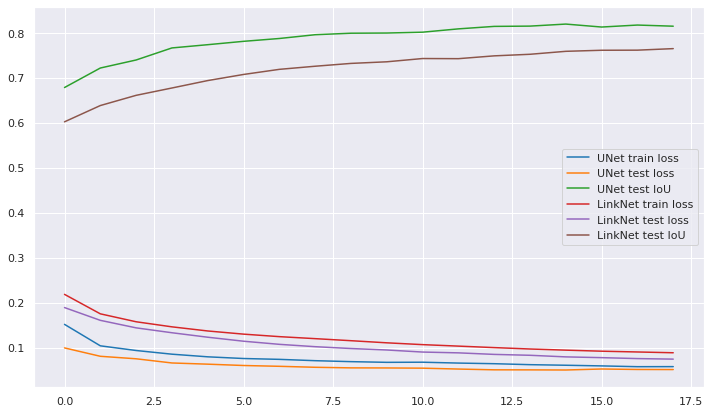

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7))
plt.plot(m_results1[0][0], label='UNet train loss')
plt.plot(m_results1[0][1], label='UNet test loss')
plt.plot(m_results1[0][2], label='UNet test IoU')

plt.plot(m_results2[0][0], label='LinkNet train loss')
plt.plot(m_results2[0][1], label='LinkNet test loss')
plt.plot(m_results2[0][2], label='LinkNet test IoU')

plt.legend()
plt.show()

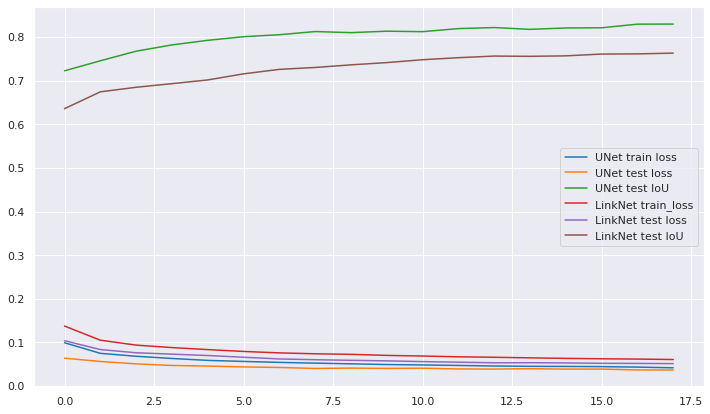

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7))
plt.plot(m_results1[1][0], label='UNet train loss')
plt.plot(m_results1[1][1], label='UNet test loss')
plt.plot(m_results1[1][2], label='UNet test IoU')

plt.plot(m_results2[1][0], label='LinkNet train_loss')
plt.plot(m_results2[1][1], label='LinkNet test loss')
plt.plot(m_results2[1][2], label='LinkNet test IoU')

plt.legend()
plt.show()

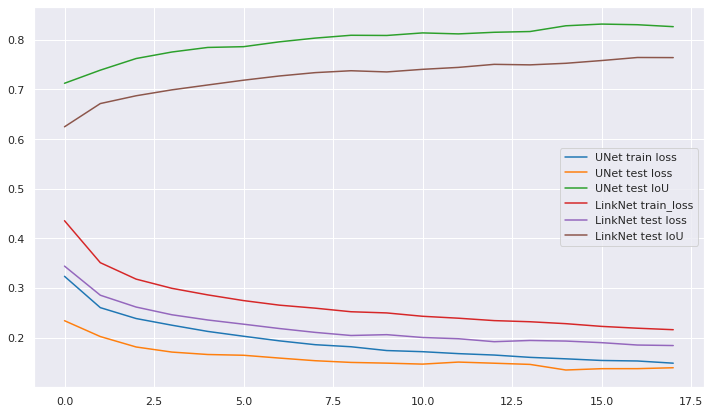

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7))
plt.plot(m_results1[2][0], label='UNet train loss')
plt.plot(m_results1[2][1], label='UNet test loss')
plt.plot(m_results1[2][2], label='UNet test IoU')

plt.plot(m_results2[2][0], label='LinkNet train_loss')
plt.plot(m_results2[2][1], label='LinkNet test loss')
plt.plot(m_results2[2][2], label='LinkNet test IoU')

plt.legend()
plt.show()

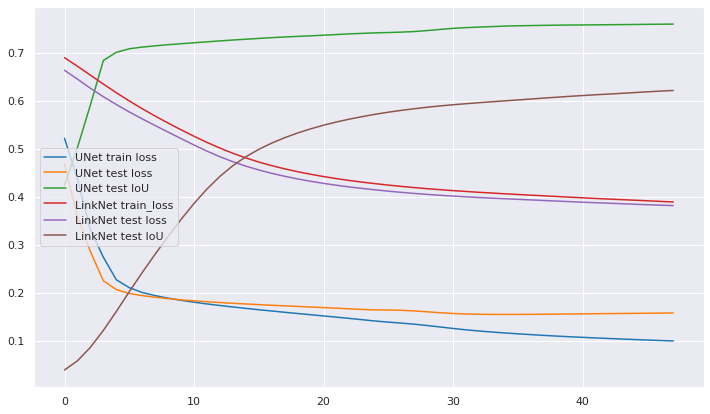

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7))
plt.plot(m_results1[3][0], label='UNet train loss')
plt.plot(m_results1[3][1], label='UNet test loss')
plt.plot(m_results1[3][2], label='UNet test IoU')

plt.plot(m_results2[3][0], label='LinkNet train_loss')
plt.plot(m_results2[3][1], label='LinkNet test loss')
plt.plot(m_results2[3][2], label='LinkNet test IoU')

plt.legend()
plt.show()

Обучите LinkNet. Сравните LinkNet и Unet по качеству и скорости работы. Сделайте выводы. 

## Теоретические вопросы (1 балл)

### Вопрос 1.
* Сформулируйте два предположения о структуре входных данных, на которые опирается архитектура сверточных сетей. 
* Какие преимущества дает использование сверток в случае, если эти предположения верные? 
* Приведите пример входных данных, когда эти предположения не выполняются.

1. Архитектура сверточных сетей опирается на следующую структуру входных данных:
    - локальность данных, как следствие связная структура (близкие по таргету пиксели находятся рядом)
    - "картинка" формата CxHxW - тензор
2. Следующие преимущества дает использование сверток в случае, если эти предположения верные:
    - учитывается окрестность пикселя, увеличеваем кол-во свёрток -> увеличиваем больший receptive field
    - используем достаточно мало параметров (в отличии от fully connected layers)
3. Примеры входных данных, когда эти предположения не выполняются:
    - данные имеют графое представление (напрямую нельзя применять свёртки)
    - метка распределена малыми областями в большом количестве на картинке

### Вопрос 2
Пусть дано множество 1-D входов ${x^{(i)} \in \mathbb{R}^{100}}$. 

Рассмотрим полносвязный слой ${f(\cdot)}$, заданный как ${f(x^{(i)}) = \sigma(Wx^{(i)})}$, где ${W}$ - матрица весов размерности ${1000\times 100}$ и ${\sigma(\cdot)}$ поэлементая функция активации. 

Рассмотрим также сверточный слой ${g(\cdot)}$ с десятью картами признаков: ${g(x^{(i)}) = \sigma([z_1, z_2,...,z_{10}])}$, где ${z_j = x^{(i)}\ast w_j}$ для некоторого ядра свертки ${w_j}$ с размером 3 и паддингом 1. Для ${f(\cdot)}$ и ${g(\cdot)}$ напишите: 

1. Размерность выходного пространства. 
2. Количество обучаемых параметров. 
3. Число операций при выполнении forward pass (при условии наивной реализации перемножения матриц и вычисления сверток).

${f(\cdot)}$:  
1. 1000
2. 1000 x 100
3. (100 умн. + 99 сл.) * 1000  + 1000 сигмоид = 200 000 операций

${g(\cdot)}$:  
1. (10, 1, 1, 100)
2. 10 * 3 = 30
3. 2 * 10 пад. + (2 сл. + 3 умн.) * 100 * 10 + 10 * 100 сигмоид = 6020 операции 


## Бонус: постобработка изображений (1 балл)

В предложенной задаче на фотографиях необходимо сегментировать только центральное изображения. Артефакты, которые появляются на краях изображения, можно удалять с помощью постобработки (например, с помощью модуля https://scikit-image.org/docs/dev/api/skimage.morphology.html). 

Реализуйте какой-нибудь из методов постобработки, дающий прирост в качестве. Продемонстируйте несколько изображений, на которых постобработка будет оказывать влияние на результат сегментации.

In [ ]:
!pip install scikit-image
!pip install pillow
!pip install argparse

from skimage import filters, exposure, morphology, feature, util

In [ ]:
from skimage import img_as_ubyte
import albumentations as A
import random, math
import cv2

In [ ]:
show_idx_image(train_dataset_2, 222), show_idx_image(train_dataset_2, 222), show_idx_image(train_dataset_2, 222), show_idx_image(train_dataset_2, 222)

In [ ]:
class Smooth_mask(object):
    def __init__(self, p=1):
        self.p = p
        self.transform = True

    @with_probability
    def __call__(self, **params):
        if self.transform:
            params['targ'] = Image.fromarray(morphology.closing(np.array(params['targ'])).astype(np.uint8))
        return params


class Hog(object):
    def __init__(self, p=1):
        self.p = p
        self.transform = True

    @with_probability
    def __call__(self, **params):
        if self.transform:
            fd, im = feature.hog(np.array(params['img']), visualize=True, multichannel=True)
            temp = np.array(params['img'], float)

            im *= 255

            for i in range(3):
                temp[:, :, i] = 0.95 * temp[:, :, i] + 0.05 * im
                temp[:, :, i][temp[:, :, i] < 0] = 0
                temp[:, :, i][temp[:, :, i] > 255] = 255

            params['img'] = Image.fromarray(temp.astype(np.uint8))
        return params


class JpegComperssion(object):
    def __init__(self, p=0.5, l_q=4, h_q=15):
        self.transform = True
        self.tr = A.augmentations.transforms.JpegCompression(l_q, h_q, p=p)

    def __call__(self, **params):
        if self.transform:
            cv_image = np.array(params['img'], np.uint8)
            res = self.tr(image=cv_image)['image']
            params['img'] = Image.fromarray(res)
        return params
    

In [ ]:
DATA_PATH = path

train_transforms_2 = [
    Crop(0.5),
    HorizontalFlip(0.5),
    Brightness(0.5),
    ChangeBackground(0.01),
    # Erase(0.0),
    JpegComperssion(),
    # Hog(),
    # Smooth_mask(),
    tvis.transforms.ToTensor(),
    tvis.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
]

test_transforms_2 = [
    # Hog(),
    tvis.transforms.ToTensor(),
    tvis.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
]

not_my_transforms_train = [len(train_transforms_2) - 2, len(train_transforms_2) - 1]
not_my_transforms_test = [len(test_transforms_2) - 2, len(test_transforms_2) - 1]
need_mask_transf_train = [len(train_transforms_2) - 2]
need_mask_transf_test = [len(test_transforms_2) - 2]

train_dataset_2 = PhotosDataset(
    images_dir=DATA_PATH + 'train/',
    target_dir=DATA_PATH + 'train_mask/',
    transforms=train_transforms_2,
    not_my_transforms=not_my_transforms_train,
    need_mask_transf=need_mask_transf_train,
    background_path=DATA_PATH + 'background/'
)

test_dataset_2 = PhotosDataset(
    images_dir=DATA_PATH + 'test/',
    target_dir=DATA_PATH + 'test_mask/',
    transforms=test_transforms_2,
    need_mask_transf=need_mask_transf_test,
    not_my_transforms=not_my_transforms_test,
    background_path=DATA_PATH + 'background/'
)

train_data_loader = DataLoader(train_dataset_2, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
test_data_loader = DataLoader(test_dataset_2, batch_size=8, num_workers=2, pin_memory=True)

In [ ]:
criterions = [torch.nn.BCEWithLogitsLoss]
criterions_names = ['BCEWithLogitsLoss']

In [ ]:
results1 = []
model = []
ind_cr = 0
delta_loss = 1e-4
count = 0

for criterion in criterions:
    n_epochs = 20
    Train_loss = []
    Test_loss = []
    Test_acc = []

    del model
    gc.collect()
    torch.cuda.empty_cache()

    model = UNet()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-5, weight_decay=1e-4)

    for i in range(n_epochs):
        print('Epoch {0}'.format(i+1), end='\n')
        train_loss = train_epoch(model, train_data_loader, criterion(), optimizer)
        test_loss, test_acc = test_model(model, test_data_loader, criterion(), iou_pytorch, 'IoU')
        Train_loss.append(train_loss)
        Test_loss.append(test_loss)
        Test_acc.append(test_acc)
        print('='*20)
        # display.clear_output(wait=True)
        if i > 1 and abs(Test_loss[-1] - Test_loss[-2]) < delta_loss:
            count += 1
            if count >= 5:
                break   
        else:
            count = 0 
    results1.append([Train_loss, Test_loss, Test_acc])
    print('_____________Training_' + criterions_names[ind_cr] + '_Finished')
    ind_cr += 1

Epoch 1
Training Loss:     0.4354866829496869 Time: 30 s
Testing Loss:      0.27630386667119133
Testing IoU:       0.6771024680799909
Epoch 2
Training Loss:     0.28968876432737656 Time: 31 s
Testing Loss:      0.22287834766838285
Testing IoU:       0.7203212281068166
Epoch 3
Training Loss:     0.2709507105442194 Time: 31 s
Testing Loss:      0.2342478268676334
Testing IoU:       0.722112301323149
Epoch 4
Training Loss:     0.2467252720125328 Time: 31 s
Testing Loss:      0.19873294565412733
Testing IoU:       0.7393611636426713
Epoch 5
Training Loss:     0.22932667809830615 Time: 31 s
Testing Loss:      0.17648847235573661
Testing IoU:       0.7640700704521604
Epoch 6
Training Loss:     0.2163509929762084 Time: 31 s
Testing Loss:      0.16764258841673532
Testing IoU:       0.7732558217313554
Epoch 7
Training Loss:     0.2091087563150733 Time: 31 s
Testing Loss:      0.16563261300325394
Testing IoU:       0.7768762111663818
Epoch 8
Training Loss:     0.1966963137042593 Time: 31 s
Testi

Тут train loss - среднее лосс по батчам на трейне (поэтому иногда train loss > test loss, но в реальности это не так)

In [ ]:
# del xmp
# import torch_xla.distributed.xla_multiprocessing as xmp

In [ ]:
ind = 0

for cr in criterions:
    print('____Learning__with__' + criterions_names[ind])

    md_unet = UNet()

    flags = {}
    flags['batch_size'] = 8
    flags['num_epochs'] = 50
    flags['criterion'] = cr
    flags['lr'] = 3e-5
    flags['weight_decay'] = 1e-4
    flags['metrics_name'] = criterions_names[ind] + '_enhace1'
    flags['model_name'] = criterions_names[ind] + '_enhace1'

    xmp.spawn(map_fn, args=(flags,), nprocs=8, start_method='fork')
    ind += 1

## Бонус: существенное улучшение качества (2 балла)

Придумайте какой-нибудь трюк, который существенно (с учётом бонусного пункта 1) повысит качество (которое должно быть и так достаточно высоко). Не разрешается использовать дополнительные данные или другие предобученные кодировщики кроме VGG13.

Если вы что-то попробовали, но качество не повысилось, всё равно оформите этот пункт, даже за неудачные попытки могут быть начислены баллы.

## Бонус: обучение с использованием сторонних фреймворков (1 балл)

Попробуйте обучить свою модель с использованием одного из следующих фреймворков: catalyst, pytorch-lightning, kekas.

In [ ]:
class LitModel(py_l.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = UNet()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y)
        return {'loss': loss}
    
    def training_epoch_end(self, outputs):
        all_train_loss = torch.stack([x['loss'] for x in outputs])
        self.log('loss', all_train_loss.mean().detach(), prog_bar=True)
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y)
        out = y_hat
        out = torch.sigmoid(out)
        out[out < 0.5] = 0
        out[out >= 0.5] = 1
        out = out.long()
        iou = iou_pytorch(out, y.long())
        return {'iou': iou, 'test_loss': loss}
    
    def validation_epoch_end(self, outputs):
        all_iou = torch.stack([x['iou'] for x in outputs])
        all_test_loss = torch.stack([x['test_loss'] for x in outputs])
        avg_iou = all_iou.mean().detach()
        avg_test_loss = all_test_loss.mean().detach()

        # print('Epoch ' + str(self.current_epoch), end='\n')
        # print('Test loss: {0}\nTest IoU: {1}\n'.format(avg_test_loss, avg_iou))

        self.log('test_loss', avg_test_loss, prog_bar=True)
        self.log('test_iou', avg_iou, prog_bar=True)
    

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=3e-5, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
        return [optimizer], [scheduler]

In [ ]:
checkpoint_callback = py_l.callbacks.ModelCheckpoint(dirpath=path + 'checkpoints/',
                                                     filename="{epoch:02d}_{test_loss:.4f}",
                                                     save_top_k=1, 
                                                     monitor='test_loss', 
                                                     mode='min')

In [ ]:
model = LitModel()
trainer = py_l.Trainer(gpus=1,
                       precision=16 if 1 else 32,
                       max_epochs=30,
                       checkpoint_callback=checkpoint_callback,
                       default_root_dir=path + 'logs/')
trainer.fit(model, 
            train_data_loader, 
            test_data_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | UNet | 8.6 M 
-------------------------------
8.6 M     Trainable params
0         Non-trainable params
8.6 M     Total params
34.230    Total estimated model params size (MB)


1